In [164]:
using Revise

In [165]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;


In [166]:
const λ = 1
const Γ = 2π
const m = 1
const k = 2π / λ
;

In [205]:
H_operator = :(
    T * L +
    B_z * Zeeman_L0
)
parameters = @params begin
    T = 1.0
    B_z = 0.5
end

# Create basis states
QN_bounds = (L = 0, N = 1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

# 
# TDM_x1(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, +x̂)))
# TDM_x2(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, -x̂)))
TDM_σ0(state, state′) = TDM(state, state′, 0) + conj(TDM(state′, state, 0))
H = add_to_H(H, :s, TDM_σ0)
H.parameters.s = 2.0

evaluate!(H)
QuantumStates.solve!(H)

update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
# d_copy = d[:,:,:]
# for j in 1:1:6
#    d[:, j, :] =  d[:, j, :]./ sqrt(sum(norm.(d_copy[:, j, 1]).^2) + sum(norm.(d_copy[:, j, 2]).^2) + sum(norm.(d_copy[:, j, 3]).^2)) 
# end

# d[1:3,1:3,:] .= 0.0
# d[4:6,4:6,:] .= 0.0
# d[1:3, 4:6, 1] ./= sqrt(sum(d[1:3, 4:6, 1].^2))
# d[4:6, 1:3, 1] ./= sqrt(sum(d[4:6, 1:3, 1].^2))
# d[1:3, 4:6, 2] ./= sqrt(sum(d[1:3, 4:6, 2].^2))
# d[4:6, 1:3, 2] ./= sqrt(sum(d[4:6, 1:3, 2].^2))
# d[1:3, 4:6, 3] ./= sqrt(sum(d[1:3, 4:6, 3].^2))
# d[4:6, 1:3, 3] ./= sqrt(sum(d[4:6, 1:3, 3].^2))
;

In [206]:
energy.(H.states)

6-element Vector{Float64}:
 -1.350781059358211
 -0.6861406616345054
  0.0
  1.0
  1.8507810593582124
  2.186140661634507

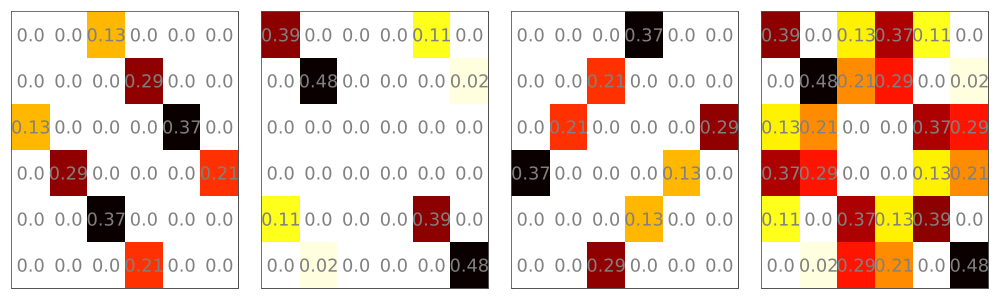

In [207]:
using Plots
tdms_squared = norm.(d[:,:,:]).^2

plot(
    size=(1000,300),
    box=:on,
    layout=(1,4)
    )
heatmap!(tdms_squared[:,:,1], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=1, ticks=nothing, colorbar=nothing)
heatmap!(tdms_squared[:,:,2], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=2, ticks=nothing, colorbar=nothing)
heatmap!(tdms_squared[:,:,3], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=3, ticks=nothing, colorbar=nothing)
heatmap!(sum(tdms_squared, dims=3)[:,:,1], c=cgrad(:hot, rev=true), legend=:none, yflip=true, subplot=4, ticks=nothing, colorbar=nothing)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(tdms_squared[i,j,1], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=1)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(tdms_squared[i,j,2], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=2)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(tdms_squared[i,j,3], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=3)

nrow, ncol = size(tdms_squared[:,:,1])
ann = [(j,i, text(round(sum(tdms_squared, dims=3)[i,j,1], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, subplot=4)

In [301]:
test

18-element Weights{Float64, Float64, Vector{Float64}}:
 0.0
 0.0
 0.00800570423520443
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.007944931944915665
 0.0
 0.0
 0.3902439024390244
 0.0
 0.1328696785835454
 0.3671303214164547
 0.10975609756097571
 0.0

In [302]:
test = Weights([laser1_rate[1,:]; laser2_rate[1,:]; spontaneous_rate[1,:]])
sample(test)

15

In [333]:
using StatsBase

s = 1.0 #saturation parameter

# detuning and saturation factor
det_factor = ([1+4*(energy(H.states[j]) - energy(H.states[i]))^2 for i ∈ 1:1:length(H.states), j ∈ 1:1:length(H.states)].^(-1)).*(s/2)


laser1_rate = ((norm.(d[:,:,1])).^2).*det_factor


laser2_rate = ((norm.(d[:,:,3])).^2).*det_factor

spontaneous_rate = sum(((norm.(d)).^2), dims=(3))
    
transition_rates = [Weights([laser1_rate[i,:]; laser2_rate[i,:]; spontaneous_rate[i,:]]) for i ∈ 1:length(H.states)]

tdms_squared_det = tdms_squared[:,:,:]
tdms_squared_det[:,:,1] = tdms_squared[:,:,1] .* det_factor
tdms_squared_det[:,:,2] = tdms_squared[:,:,2] .* det_factor
tdms_squared_det[:,:,3] = tdms_squared[:,:,3] .* det_factor


# rates_i_wvs = [Weights(vec(tdms_squared_det[i,:,:])) for i ∈ 1:length(H.states)]
# rates_j_wvs = [Weights(vec(tdms_squared[:,j,:])) for j ∈ 1:length(H.states)]
cart_indices = CartesianIndices(tdms_squared[1,:,:])
;

In [326]:
transition!(1, transition_rates)

13

In [327]:
H.states[1]

State{AngularMomentumState_Labelled}(-1.350781059358211, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.8568900996235802 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.5154991340119698 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

In [340]:
decomposition_weights = [Weights(norm.(H.states[i].coeffs).^2) for i ∈ 1:length(H.states)];

In [303]:
transition!(state, rates_weight) = sample(rates_weight[state])
# scatter_photon!(state, rates_i_wvs, cart_indices) = cart_indices[sample(rates_i_wvs[state])]
# decay!(state, rates_j_wvs, cart_indices) = cart_indices[sample(rates_j_wvs[state])]
# ;

transition! (generic function with 2 methods)

In [331]:
1 ÷ 13

0

In [348]:
n_trap = []
n_antitrap = []


@time for nn in 1:1:10000
    n = 5000
    current_state = 1
    prev_state = 1
    trap_scatters = 0
    antitrap_scatters = 0
    for i ∈ 1:n
        prev_state = current_state
        current_state = transition!(current_state, transition_rates)
        path = current_state ÷ length(H.states)
        current_state = current_state % length(H.states) + 1
        if path == 0
            eg = sample(decomposition_weights)
            if eg == 1
                trap_scatters += 1
            elseif eg == 2
                trap_scatters -= 1
            end
        elseif path == 1
            eg = sample(decomposition_weights[current_state])
            if eg < 1
                antitrap_scatters += 1
            elseif eg == 2
                antitrap_scatters -= 1
            end
        end
        
    end
    push!(n_trap, trap_scatters)
    push!(n_antitrap, antitrap_scatters)
end
# trap_scatters |> display
# antitrap_scatters |> display

  6.627135 seconds (16 allocations: 652.969 KiB)


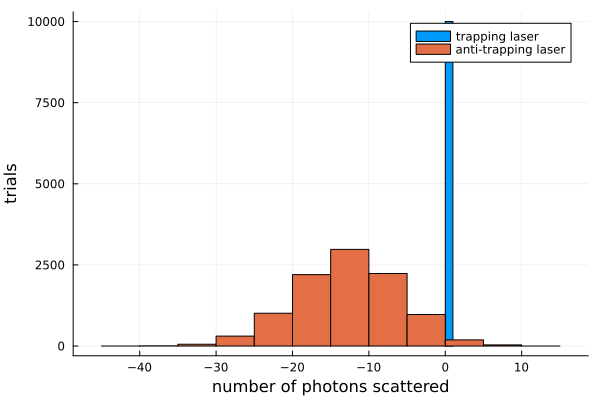

In [349]:
histogram(n_trap, label="trapping laser",bins=20)
histogram!(n_antitrap, label="anti-trapping laser",xlabel="number of photons scattered",ylabel="trials",bins=20)


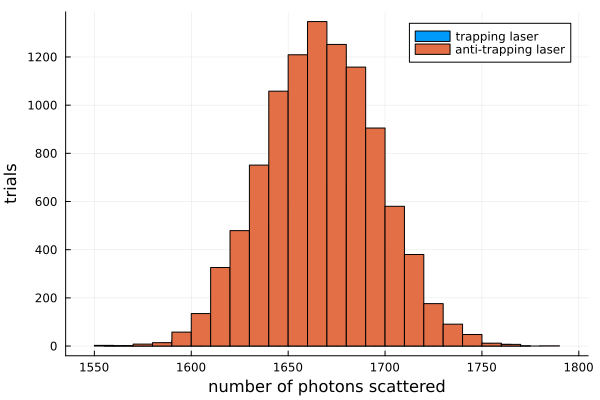

In [158]:
# without considering detuning due to stark shift
histogram(n_trap, label="trapping laser",bins=40)
histogram!(n_antitrap, label="anti-trapping laser",xlabel="number of photons scattered",ylabel="trials",bins=40)


In [16]:
B_scan = collect(LinRange(0,2,101))
energies = zeros((length(B_scan),3))
    
for i in 1:1:length(B_scan)
    H.parameters.B_z = B_scan[i]
    evaluate!(H)
    QuantumStates.solve!(H)
    energies[i,1] = energy(H.states[4])
    energies[i,2] = energy(H.states[5])
    energies[i,3] = energy(H.states[6])
end

In [17]:
display(H.states[4])

State{AngularMomentumState_Labelled}(1.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -1.0 + 0.0im, 0.0 + 0.0im], 4)

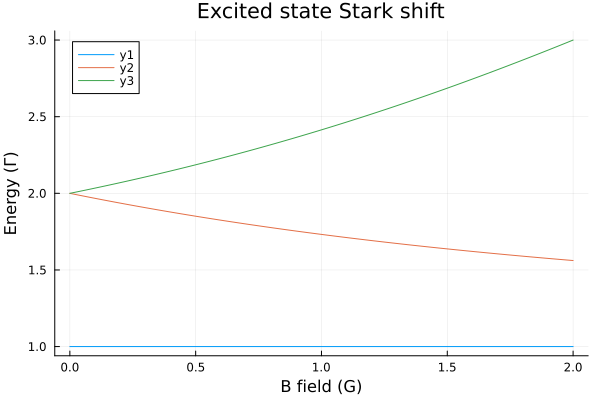

In [18]:
plot(B_scan, energies[:,1])
plot!(B_scan, energies[:,2])
plot!(B_scan, energies[:,3])
plot!(xlabel="B field (G)", ylabel="Energy (Γ)", title="Excited state Stark shift")

In [19]:
H.states[1] |> display
H.states[2] |> display
H.states[3] |> display

State{AngularMomentumState_Labelled}(-2.5615528128088294, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.9294102633145922 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.36904818444953835 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2)

State{AngularMomentumState_Labelled}(2.220446049250313e-15, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, -0.577350269189626 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.8164965809277258 - 0.0im], 3)

In [20]:
H.states[4] |> display
H.states[5] |> display
H.states[6] |> display

State{AngularMomentumState_Labelled}(1.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -1.0 + 0.0im, 0.0 + 0.0im], 4)

State{AngularMomentumState_Labelled}(1.5615528128088303, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[-0.3690481844495384 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.9294102633145922 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 5)

State{AngularMomentumState_Labelled}(3.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, -0.8164965809277259 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -0.577350269189626 - 0.0im], 6)

In [21]:
# Laser parameters
Δ = +5.0Γ
s = 40.0

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (energy(H.states[4]) - energy(H.states[2])) + Δ
ω2 = 2π * (energy(H.states[end]) - energy(H.states[4])) - Δ

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω1, s)
k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω1, s)
k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω1, s)
k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω1, s)

k̂ = +x̂; ϵ1 = ϵ_(σ⁰); laser1_orthog = Field(k̂, ϵ1, ω1, s)
k̂ = -x̂; ϵ2 = ϵ_(σ⁰); laser2_orthog = Field(k̂, ϵ2, ω1, s)

lasers = [laser1_orthog, laser2_orthog, laser5, laser6]
;

In [22]:
particle = Particle()
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0
freq_res = 1e-1

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

t_end = 10p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [23]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.3) .* 2π
prob.p.v = (0., 0., 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  6.518565 seconds (13.67 M allocations: 884.448 MiB, 5.48% gc time, 99.71% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.0
 42.44559540028233

In [24]:
prob.p.populations

6-element Vector{ComplexF64}:
  0.24455970438782948 + 0.0im
  0.22406696717359315 + 0.0im
   0.3783415807779544 + 0.0im
 0.016462710442272738 + 0.0im
  0.10495604642670413 + 0.0im
  0.03161299079164626 + 0.0im

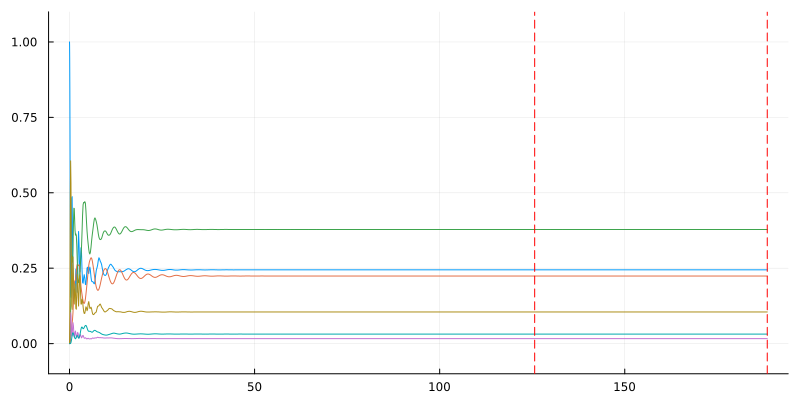

In [25]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

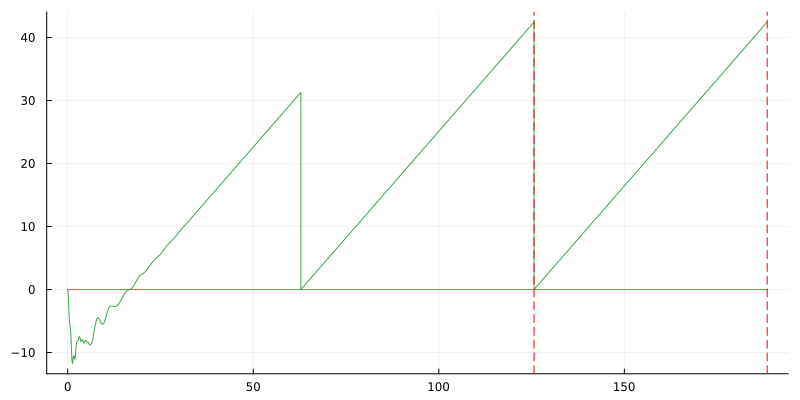

In [26]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [27]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Force versus magnetic field

In [28]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [29]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = (0:0.1:4.0)
di = 8
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0.0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [30]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17m


 17.585448 seconds (21.06 M allocations: 2.745 GiB, 2.33% gc time, 633.23% compilation time)


In [31]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.132472 seconds (182.98 k allocations: 13.887 MiB, 91.42% compilation time)


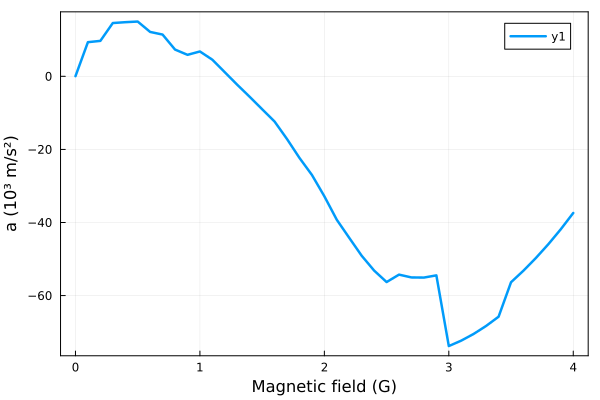

In [32]:
plot(Bs, 1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    # labelfontsize=14,
    # tickfont=12,
    # legendfont=11,
    # ylim=(-3,23),
    # size=(600,500)
    )

In [33]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.104547 seconds (100.08 k allocations: 10.158 MiB, 95.03% compilation time)


In [136]:
function prob_func_re!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v[3] = scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    new_p = remake_rate_equation_B(p, scan_params[i].B)
    return remake(prob, p=new_p)
end
;

In [162]:
using RectiGrids
N0 = [1.0,0,0,0,0,0]
freq_res = 1e-1
extra_p = (H=H, lasers=lasers, n_ground=3)

particle.v = [0,0,1.0]

p = rate_equation(N0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
cb = PeriodicCallback(reset_force1!, p.period)
prob = ODEProblem(N!, p.N0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = (0:0.1:4.0)
rs = [0]
vs = [0.]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)

@time forces, populations = force_scan_v3(prob, scan_values_grid, prob_func_re!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.183342 seconds (3.03 M allocations: 501.771 MiB, 37.67% gc time)


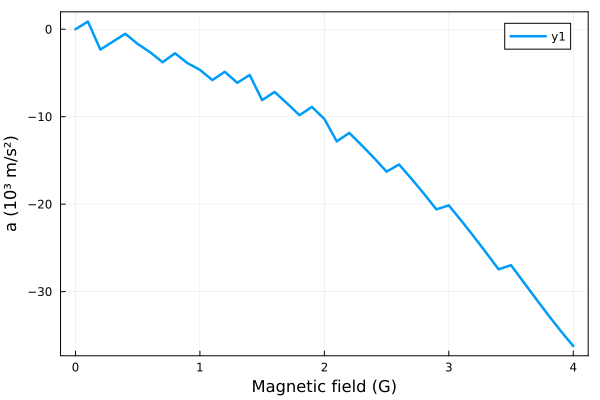

In [163]:
plot(Bs, 1e3 .* [f[3] for f in forces],
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    # labelfontsize=14,
    # tickfont=12,
    # legendfont=11,
    # ylim=(-3,23),
    # size=(600,500)
    )

In [131]:
prob.p.v

3-element MVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 1.0

In [159]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Revise,
StaticArrays
;

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo

using Parameters

import ProgressMeter: Progress, next!



function N!(dN, N, rate_eq, τ)
    @unpack H,Hv, N0, N0_vec, ω, states, fields, r, v, Γ, λ, k, freq_res, d, R, v_prev, particle, extra_p= rate_eq
    if v_prev != v
        particle.v = v
        new_rate_eq = rate_equation(N0, particle, states, fields, d, d, true, true,λ, Γ, freq_res, extra_p)
        rate_eq.H = new_rate_eq.H
        rate_eq.Hv = new_rate_eq.Hv
        rate_eq.R = new_rate_eq.R
        rate_eq.v_prev = v
    end
    n_states = length(states)
    n_fields = length(fields)
    type_complex = ComplexF64
    n_l = extra_p.n_ground
    n_u = n_states - n_l
    n_fields = length(fields)
    

    dN[:] .= 0.0
    
    # update dN

    dN[1:n_states] += H * N[1:n_states]

    
    # update integrated population
    dN[n_states+1 : end-3] = N[1:n_states]

    
    row_of_1 = StructArray(ones(type_complex, 1,n_states))

    # update force
    for p in 1:1:n_fields
    dN[end-2:end] += fields[p].k * (row_of_1 * Hv[:,:,p] * N[1:n_states])[1]
    end

    return nothing
end


function rate_equation(N0, particle, states, fields, d, d_m, should_round_freqs, alway_true, λ=1.0, Γ=2π, freq_res=1e-2, extra_p=nothing)

    period = 2π / freq_res

    n_states = length(states)
    n_fields = length(fields)

    states = StructArray(states)
    if n_fields > 0
        fields = StructArray(fields)
    end
    
    k = 2π / λ
    # particle.r0 *= 2π #(1 / k)  # `r` is in units of 1/k
    # particle.v /= (Γ / k) # velocity is in units of Γ/k
    # Convert to angular frequencies
    for i ∈ eachindex(fields)
        fields.ω[i] /= Γ
    end
    for i ∈ eachindex(states)
        states.E[i] *= 2π
        states.E[i] /= Γ
    end

    if should_round_freqs
        round_freqs!(states, fields, freq_res)
        particle.v = round_vel(particle.v, freq_res)
    end

    r0 = particle.r0
    r = particle.r
    v = particle.v
    v_prev = particle.v

    type_complex = ComplexF64


    ω = [state.E for state ∈ states]
    force_last_period = SVector(0.0, 0.0, 0.0)

    # matrix that updates populations:
    H = StructArray( zeros(type_complex, n_states, n_states) )
    n_l = extra_p.n_ground
    n_u = n_states - n_l
    n_fields = length(fields)

    # define R 
    R = StructArray(zeros(type_complex, n_l, n_u, n_fields))
    for p in 1:1:n_fields
        pol = fields[p].ϵ(0) #spherical
        # pol_cart = [(pol[1]-pol[3])/sqrt(2), (pol[1]+pol[3])/sqrt(2)*(-1im), pol[2]]
        for i in 1:1:n_l
            for j in 1:1:n_u
                ω_ij = energy(states[n_l + j]) - energy(states[i])
                ω_p = fields[p].ω
                doppler = 2π*fields[p].k ⋅ v
                f = -1 * pol[1]*d[i,n_l + j,3] + 1*pol[2]*d[i,n_l + j,2] - 1*pol[3]*d[i,n_l + j,1] 
                R[i,j,p] = 1/2 * real(f*conj(f)) * fields[p].s / (1 + 4*(ω_p - ω_ij - doppler)^2)
            end
        end
    end

    
    X = StructArray( zeros(type_complex, n_l, n_l, n_fields))
    for p in 1:1:n_fields
        for i in 1:1:n_l
            X[i,i,p] = sum(R[i,:,p])
        end
    end

    Y = StructArray(zeros(type_complex, n_u, n_u, n_fields))
    for p in 1:1:n_fields
        for j in 1:1:n_u
            Y[j,j,p] = sum(R[:,j,p])
        end
    end

    # define r (branching ratio of spontaneous decay)
    r = StructArray(zeros(type_complex, n_l, n_u))
    for i in 1:1:n_l 
        for j in 1:1:n_u 
            r[i,j] = norm(d[i,n_l + j,1])^2 + norm(d[i,n_l + j,2])^2 + norm(d[i,n_l + j,3])^2 
        end
    end

    # make sure population is conserved --- decay into lower = decay out from upper
    for j in 1:1:n_u
#         print( sum(r[:,j]))
        r[:,j] = r[:,j]./ sum(r[:,j])
    end

    id_l = Matrix((1.0+0im)LinearAlgebra.I, n_l, n_l)
    id_u = Matrix((1.0+0im)LinearAlgebra.I, n_u, n_u)

    H = StructArray(zeros(type_complex, n_states, n_states))
    for p in 1:1:n_fields
        H[1:n_l, 1:n_l] += -X[:,:,p]
        H[1:n_l, n_l+1:n_states] += R[:,:,p]
        H[n_l+1: n_states, 1:n_l] += transpose(R[:,:,p])
        H[n_l+1: n_states, n_l+1: n_states] += -Y[:,:,p]
    end

    
    H[1:n_l, n_l+1:n_states] += r[:,:]
    H[n_l+1:n_states, n_l+1:n_states] += -id_u

    # update matrix for force
    Hv = StructArray(zeros(type_complex, n_states, n_states, n_fields))
    for p in 1:1:n_fields
        Hv[1:n_l, n_l+1:n_states, p] = -R[:,:,p]
        Hv[n_l+1:end, 1:n_l, p] = transpose(R[:,:,p])
    end

    N0_vec=[N0; N0; 0;0;0]
    populations = N0[:];

    p = MutableNamedTuple(
        H=H, Hv=Hv, particle=particle, N0=N0, N0_vec=N0_vec, ω=ω,
        states=states, fields=fields, r0=r0, r=r, v=v, Γ=Γ, λ=λ,
        period=period, k=k, freq_res=freq_res,
        force_last_period=force_last_period, 
        d=d, 
        extra_p=extra_p, R=R, populations= populations, v_prev=v)

    return p
end
function round_freqs!(states, fields, freq_res)
    """
    Rounds frequencies of state energies and fields by a common denominator.
    
    freq_res::Float: all frequencies are rounded by this value (in units of Γ)
    """
    for i in eachindex(fields)
        fields.ω[i] = round_freq(fields.ω[i], freq_res)
    end
    for i in eachindex(states)
        states.E[i] = round_freq(states.E[i], freq_res)
    end
    return nothing
end


function reset_force1!(integrator)
    force_current_period = integrator.u[end-2:end] / integrator.p.period
    force_diff = abs(norm(force_current_period) - norm(integrator.p.force_last_period))
    force_diff_rel = force_diff / norm(integrator.p.force_last_period)
    integrator.p.force_last_period = force_current_period
    
    n = length(integrator.p.states)
    integrator.p.populations .= integrator.u[n+1:end-3] / integrator.p.period

    force_reltol = 1e-4
    if (force_diff_rel < force_reltol) #|| (force_diff < 1e-6)
        terminate!(integrator)
    else
        integrator.u[end-2:end] .= 0.0
        integrator.u[n+1:end-3] .= 0.0
    end
    return nothing
end


function force_scan_v3(prob::T1, scan_values::T2, prob_func!::F1, output_func::F2; n_threads=Threads.nthreads()) where {T1,T2,F1,F2}

    n_values = reduce(*, size(scan_values))
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    forces = Array{SVector{3, Float64}}(undef, n_values)
    populations = zeros(Float64, n_values, length(prob.p.states))

    prog_bar = Progress(n_values)

    Threads.@threads for i ∈ 1:n_threads
        prob_copy = deepcopy(prob)
        # Threads.@spawn begin
            # prob_func!(_prob, scan_values, i)
        force_cb = PeriodicCallback(reset_force1!, prob_copy.p.period)
        if :callback ∈ keys(prob_copy.kwargs)
            cbs = prob_copy.kwargs[:callback]
            prob_copy = remake(prob_copy, callback=CallbackSet(cbs, force_cb))
        else
            prob_copy = remake(prob_copy, callback=force_cb)
        end
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)
        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1)
            prob_j = prob_func!(prob_copy, scan_values, j)
            sol = solve(prob_j, alg=DP5())
            forces[j] = output_func(prob_j.p, sol)
            prob_j.p.force_last_period = (0, 0, 0)

            populations[j,:] .= prob_j.p.populations

            next!(prog_bar)
        end
    end
    return forces, populations
end

force_scan_v3 (generic function with 1 method)

In [102]:
# update the whole hamiltonian.
function remake_rate_equation_B(p, B)
    λ = p.λ
    Γ = p.Γ
 
    
 
    freq_res = p.freq_res
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    states = H.states
    lasers = p.extra_p.lasers
    
    new_p = rate_equation(p.N0, p.particle, states, p.extra_p.lasers, new_d, new_d, true, true, λ, Γ, freq_res, extra_p)
    return new_p
end

remake_rate_equation_B (generic function with 1 method)